In [1]:
# %matplotlib inline 

# %matplotlib ipympl
# %matplotlib widget

In [2]:
from __future__ import (absolute_import, division, print_function, unicode_literals)

import datetime  # For datetime objects
import os.path  # To manage paths
import sys  # To find out the script name (in argv[0])

# Import the backtrader platform
import backtrader as bt

import pandas as pd
import pandas_datareader.data as web
import matplotlib.pyplot as plt

## Import data

Ascending order로 되어있어야 작동한다. 

In [3]:
kodex200_ts_d_df = pd.read_pickle('./data_files/kodex200_ts_d_df.pkl') # 
kodex200_ts_d_df = kodex200_ts_d_df.sort_index()
kodex200_ts_d_df.head()

,open,high,low,close,volume
date,,,,,
2015-12-29,22407,22554,22328,22554,4947236
2015-12-30,22609,22665,22430,22439,7619883
2016-01-04,22365,22374,21983,21983,6928106
2016-01-05,21941,22199,21941,22121,12419517
2016-01-06,22121,22144,21849,21960,10875053


In [4]:
kodex200_ts_m_df = pd.read_pickle('./data_files/kodex200_ts_m_df.pkl') # minute
kodex200_ts_m_df = kodex200_ts_m_df.sort_index()
kodex200_ts_m_df.head()

,open,high,low,close,volume
datetime,,,,,
2020-01-28 10:01:00,29749,29774,29739,29769,19646
2020-01-28 10:02:00,29779,29789,29759,29789,25290
2020-01-28 10:03:00,29789,29804,29789,29799,20806
2020-01-28 10:04:00,29794,29804,29794,29804,14493
2020-01-28 10:05:00,29804,29814,29794,29809,11647


In [5]:
class CustomPandasData(bt.feeds.pandafeed.PandasData):
    params = (
        ('datetime', None), 
        
        ('open', -1), # -1은 auto. Manually 1, 2, 3, 4, 5 로도 가능. 
        ('high', -1), 
        ('low', -1),
        ('close', -1), 
        ('volume', -1),
    )
    
    datafields = [
        'datetime', 
        'open', 
        'high', 
        'low', 
        'close', 
        'volume',
    ]

위의 CustomPandasData class 없이도 잘 된다. 

## Simple Golden Cross 

단순 골든크로스 전략. 단기이평선 ma5가 ma10을 위로 돌파하면 매수, 아래로 돌파하면 매도. 

결과는 손해. commission이 0.3% 붙기도 하고 이평선의 period를 5, 10으로 임의로 고정시켰기 때문에 +의 수익률을 기대하기 어렵다. 

In [6]:
# Create a Stratey
class GoldenCrossStrategy(bt.Strategy):
    params = (
        ('ma5period', 5),
        ('ma10period', 10)
    )

    def log(self, txt, dt=None):
        ''' Logging function fot this strategy'''
        dt = dt or self.datas[0].datetime.date(0)
        print('%s, %s' % (dt.isoformat(), txt))

    def __init__(self):
        # Keep a reference to the "close" line in the data[0] dataseries
        self.dataclose = self.datas[0].close

        # To keep track of pending orders and buy price/commission
        self.order = None
        self.buyprice = None
        self.buycomm = None

        # Add a MovingAverageSimple indicator
        self.sma5 = bt.indicators.SimpleMovingAverage(
            self.datas[0], period=self.params.ma5period)
        
        self.sma10 = bt.indicators.SimpleMovingAverage(
            self.datas[0], period=self.params.ma10period)

    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # Buy/Sell order submitted/accepted to/by broker - Nothing to do
            return

        # Check if an order has been completed
        # Attention: broker could reject order if not enough cash
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log(
                    'BUY EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                    (order.executed.price,
                     order.executed.value,
                     order.executed.comm))

                self.buyprice = order.executed.price
                self.buycomm = order.executed.comm
            else:  # Sell
                self.log('SELL EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                         (order.executed.price,
                          order.executed.value,
                          order.executed.comm))

            self.bar_executed = len(self)

        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('Order Canceled/Margin/Rejected')

        self.order = None

    def notify_trade(self, trade):
        if not trade.isclosed:
            return

        self.log('OPERATION PROFIT, GROSS %.2f, NET %.2f' %
                 (trade.pnl, trade.pnlcomm))

    def next(self):
        # Simply log the closing price of the series from the reference
        self.log('Close, %.2f' % self.dataclose[0])

        # Check if an order is pending ... if yes, we cannot send a 2nd one
        if self.order:
            return

        # Check if we are in the market
        if not self.position:

            # Not yet ... we MIGHT BUY if ...
            if self.sma5[0] > self.sma10[0]:
                
                print("Buy timing!")

                # BUY, BUY, BUY!!! (with all possible default parameters)
                self.log('BUY CREATE, %.2f' % self.dataclose[0])

                # Keep track of the created order to avoid a 2nd order
                self.order = self.buy()

        else:

            if self.sma5[0] < self.sma10[0]:
                
                print("Sell timing!")
                
                # SELL, SELL, SELL!!! (with all possible default parameters)
                self.log('SELL CREATE, %.2f' % self.dataclose[0])

                # Keep track of the created order to avoid a 2nd order
                self.order = self.sell()

Starting Portfolio Value: 1000000000.00
2016-01-13, Close, 21900.00
2016-01-14, Close, 21692.00
2016-01-15, Close, 21466.00
2016-01-18, Close, 21448.00
2016-01-19, Close, 21563.00
2016-01-20, Close, 21070.00
2016-01-21, Close, 21019.00
2016-01-22, Close, 21476.00
2016-01-25, Close, 21591.00
2016-01-26, Close, 21319.00
2016-01-27, Close, 21619.00
2016-01-28, Close, 21651.00
Buy timing!
2016-01-28, BUY CREATE, 21651.00
2016-01-29, BUY EXECUTED, Price: 21582.00, Cost: 215820.00, Comm 647.46
2016-01-29, Close, 21683.00
2016-02-01, Close, 21840.00
2016-02-02, Close, 21688.00
2016-02-03, Close, 21439.00
2016-02-04, Close, 21835.00
2016-02-05, Close, 21890.00
2016-02-11, Close, 21301.00
2016-02-12, Close, 21144.00
Sell timing!
2016-02-12, SELL CREATE, 21144.00
2016-02-15, SELL EXECUTED, Price: 21365.00, Cost: 215820.00, Comm 640.95
2016-02-15, OPERATION PROFIT, GROSS -2170.00, NET -3458.41
2016-02-15, Close, 21420.00
2016-02-16, Close, 21734.00
2016-02-17, Close, 21761.00
2016-02-18, Close, 2

2018-01-09, Close, 31954.00
2018-01-10, Close, 31748.00
2018-01-11, Close, 31585.00
2018-01-12, Close, 31643.00
2018-01-15, Close, 31715.00
2018-01-16, Close, 31964.00
Sell timing!
2018-01-16, SELL CREATE, 31964.00
2018-01-17, SELL EXECUTED, Price: 31897.00, Cost: 318780.00, Comm 956.91
2018-01-17, OPERATION PROFIT, GROSS 190.00, NET -1723.25
2018-01-17, Close, 31887.00
2018-01-18, Close, 31911.00
2018-01-19, Close, 31935.00
Buy timing!
2018-01-19, BUY CREATE, 31935.00
2018-01-22, BUY EXECUTED, Price: 31906.00, Cost: 319060.00, Comm 957.18
2018-01-22, Close, 31609.00
2018-01-23, Close, 32036.00
2018-01-24, Close, 32088.00
2018-01-25, Close, 32338.00
2018-01-26, Close, 32467.00
2018-01-29, Close, 32688.00
2018-01-30, Close, 32280.00
2018-01-31, Close, 32304.00
2018-02-01, Close, 32314.00
2018-02-02, Close, 31691.00
2018-02-05, Close, 31355.00
Sell timing!
2018-02-05, SELL CREATE, 31355.00
2018-02-06, SELL EXECUTED, Price: 30713.00, Cost: 319060.00, Comm 921.39
2018-02-06, OPERATION PROF

2019-09-19, Close, 27374.00
2019-09-20, Close, 27524.00
2019-09-23, Close, 27559.00
2019-09-24, Close, 27723.00
2019-09-25, Close, 27325.00
2019-09-26, Close, 27374.00
2019-09-27, Close, 27086.00
2019-09-30, Close, 27315.00
2019-10-01, Close, 27379.00
Sell timing!
2019-10-01, SELL CREATE, 27379.00
2019-10-02, SELL EXECUTED, Price: 27185.00, Cost: 256910.00, Comm 815.55
2019-10-02, OPERATION PROFIT, GROSS 14940.00, NET 13353.72
2019-10-02, Close, 26797.00
2019-10-04, Close, 26687.00
2019-10-07, Close, 26732.00
2019-10-08, Close, 27125.00
2019-10-10, Close, 26931.00
2019-10-11, Close, 27120.00
2019-10-14, Close, 27399.00
Buy timing!
2019-10-14, BUY CREATE, 27399.00
2019-10-15, BUY EXECUTED, Price: 27354.00, Cost: 273540.00, Comm 820.62
2019-10-15, Close, 27434.00
2019-10-16, Close, 27588.00
2019-10-17, Close, 27499.00
2019-10-18, Close, 27225.00
2019-10-21, Close, 27379.00
2019-10-22, Close, 27743.00
2019-10-23, Close, 27573.00
2019-10-24, Close, 27648.00
2019-10-25, Close, 27673.00
2019

<IPython.core.display.Javascript object>


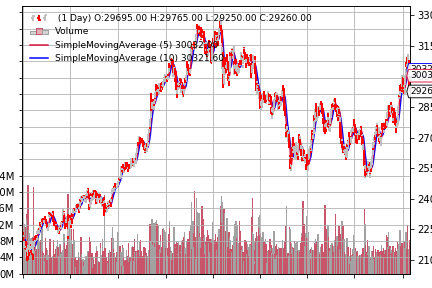

Wall time: 816 ms


In [7]:
%%time

if __name__ == '__main__':
    # Create a cerebro entity
    cerebro = bt.Cerebro(stdstats=False)

    # Add a strategy
    cerebro.addstrategy(GoldenCrossStrategy)

    # Create a Data Feed
    dataframe = kodex200_ts_d_df
    data = CustomPandasData(dataname=dataframe)

    # Add the Data Feed to Cerebro
    cerebro.adddata(data)

    # Set our desired cash start
    cerebro.broker.setcash(1000000000.0) # 10억으로 시작. 

    # Add a FixedSize sizer according to the stake
    cerebro.addsizer(bt.sizers.FixedSize, stake=10)

    # Set the commission
    cerebro.broker.setcommission(commission=0.003) # 증권거래세 0.3%

    # Print out the starting conditions
    print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

    # Run over everything
    cerebro.run()

    # Print out the final result
    print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())
    
    # Plot the result
    cerebro.plot(style='bar')
#     cerebro.plot()

# Optimizing Golden Cross

단기 이평선의 period를 조절해 가장 좋은 조합을 찾아낸다. 

당연히 딱히 investment philosophy나 reasoning이 있는 것이 아니기 때문에 현재의 데이터에 overfit 될 수밖에 없다. 

따라서 원칙적으로는 training set과 test set을 나눠줘야 한다. 

여기선 ML의 학습이라고 할 만한 것이 없기 때문에 validation은 필요 없을 것으로 보인다. 

마지막의 `def stop(self):`가 추가됐다. 

이 상태에서 그대로 위와 같이 plot하려고 하면 오류난다. 

<br>

결과적으로 `ma_short_period = 3`, `ma_long_period = 13` 일때 999960082.58 로 가장 크지만 그래도 여전히 손해다. 

회전율이 높아 여러 번 거래세를 내며 투자했는데 4만원 손해본건 그래도 선방한 것일수도.... 


In [11]:
# Create a Stratey
class GoldenCrossStrategy(bt.Strategy):
    params = (
        ('ma_short_period', 5),
        ('ma_long_period', 10)
    )

    def log(self, txt, dt=None, doprint=False):
        ''' Logging function fot this strategy'''
        if doprint:
            dt = dt or self.datas[0].datetime.date(0)
            print('%s, %s' % (dt.isoformat(), txt))

    def __init__(self):
        # Keep a reference to the "close" line in the data[0] dataseries
        self.dataclose = self.datas[0].close

        # To keep track of pending orders and buy price/commission
        self.order = None
        self.buyprice = None
        self.buycomm = None

        # Add a MovingAverageSimple indicator
        self.sma_short = bt.indicators.SimpleMovingAverage(
            self.datas[0], period=self.params.ma_short_period)
        
        self.sma_long = bt.indicators.SimpleMovingAverage(
            self.datas[0], period=self.params.ma_long_period)

    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # Buy/Sell order submitted/accepted to/by broker - Nothing to do
            return

        # Check if an order has been completed
        # Attention: broker could reject order if not enough cash
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log(
                    'BUY EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                    (order.executed.price,
                     order.executed.value,
                     order.executed.comm))

                self.buyprice = order.executed.price
                self.buycomm = order.executed.comm
            else:  # Sell
                self.log('SELL EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                         (order.executed.price,
                          order.executed.value,
                          order.executed.comm))

            self.bar_executed = len(self)

        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('Order Canceled/Margin/Rejected')

        self.order = None

    def notify_trade(self, trade):
        if not trade.isclosed:
            return

        self.log('OPERATION PROFIT, GROSS %.2f, NET %.2f' %
                 (trade.pnl, trade.pnlcomm))

    def next(self):
        # Simply log the closing price of the series from the reference
        self.log('Close, %.2f' % self.dataclose[0])

        # Check if an order is pending ... if yes, we cannot send a 2nd one
        if self.order:
            return

        # Check if we are in the market
        if not self.position:

            # Not yet ... we MIGHT BUY if ...
            if self.sma_short[0] > self.sma_long[0]:

                # BUY, BUY, BUY!!! (with all possible default parameters)
                self.log('BUY CREATE, %.2f' % self.dataclose[0])

                # Keep track of the created order to avoid a 2nd order
                self.order = self.buy()

        else:

            if self.sma_short[0] < self.sma_long[0]:
                
                # SELL, SELL, SELL!!! (with all possible default parameters)
                self.log('SELL CREATE, %.2f' % self.dataclose[0])

                # Keep track of the created order to avoid a 2nd order
                self.order = self.sell()
                
    def stop(self):
        self.log('(MA_short Period %2d), (MA_long Period %2d) Ending Value %.2f' %
                 (self.params.ma_short_period, self.params.ma_long_period, self.broker.getvalue()), doprint=True)

In [12]:
%%time

if __name__ == '__main__':
    # Create a cerebro entity
    cerebro = bt.Cerebro(stdstats=False)

    # Add a strategy
    '''
    ma_short_period=range(1, 10), 
    ma_long_period=range(10, 30),
    
    너무 오래걸린다. 대폭 줄여야 한다. 
    '''
    strats = cerebro.optstrategy(
        GoldenCrossStrategy,
        ma_short_period=range(1, 5), 
        ma_long_period=range(10, 15),
        )

    # Create a Data Feed
    dataframe = kodex200_ts_d_df
    data = CustomPandasData(dataname=dataframe)

    # Add the Data Feed to Cerebro
    cerebro.adddata(data)

    # Set our desired cash start
    cerebro.broker.setcash(1000000000.0) # 10억으로 시작. 

    # Add a FixedSize sizer according to the stake
    cerebro.addsizer(bt.sizers.FixedSize, stake=10)

    # Set the commission
    cerebro.broker.setcommission(commission=0.003) # 증권거래세 0.3%

    # Print out the starting conditions
    print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

    # Run over everything
    cerebro.run(maxcpus=1) # 최적화에 연산이 아주 오래걸린다. 원활한 작업을 위해 CPU를 제한하자. 

Starting Portfolio Value: 1000000000.00
2020-01-30, (MA_short Period  1), (MA_long Period 10) Ending Value 999887583.00
2020-01-30, (MA_short Period  1), (MA_long Period 11) Ending Value 999898028.38
2020-01-30, (MA_short Period  1), (MA_long Period 12) Ending Value 999908371.92
2020-01-30, (MA_short Period  1), (MA_long Period 13) Ending Value 999906453.35
2020-01-30, (MA_short Period  1), (MA_long Period 14) Ending Value 999909919.22
2020-01-30, (MA_short Period  2), (MA_long Period 10) Ending Value 999902885.99
2020-01-30, (MA_short Period  2), (MA_long Period 11) Ending Value 999920911.65
2020-01-30, (MA_short Period  2), (MA_long Period 12) Ending Value 999940130.79
2020-01-30, (MA_short Period  2), (MA_long Period 13) Ending Value 999939274.69
2020-01-30, (MA_short Period  2), (MA_long Period 14) Ending Value 999939652.90
2020-01-30, (MA_short Period  3), (MA_long Period 10) Ending Value 999946943.42
2020-01-30, (MA_short Period  3), (MA_long Period 11) Ending Value 999954597.31
